# Model optimization

**Table of contents**<a id='toc0_'></a>    
- 1. [Overview](#toc1_)    
  - 1.1. [Types of optimization](#toc1_1_)    
  - 1.2. [Quantization](#toc1_2_)    
- 2. [Post-training dynamic range quantization](#toc2_)    
  - 2.1. [Overview](#toc2_1_)    
  - 2.2. [Build an MNIST model](#toc2_2_)    
    - 2.2.1. [Setup](#toc2_2_1_)    
    - 2.2.2. [Train a TensorFlow model](#toc2_2_2_)    
    - 2.2.3. [Convert to a TensorFlow Lite model](#toc2_2_3_)    
  - 2.3. [Run the TFLite models](#toc2_3_)    
    - 2.3.1. [Load the model into an interpreter](#toc2_3_1_)    
    - 2.3.2. [Test the model on one image](#toc2_3_2_)    
    - 2.3.3. [Evaluate the models](#toc2_3_3_)    
  - 2.4. [Optimizing an existing model](#toc2_4_)    
- 3. [Post-training float16 quantization](#toc3_)    
  - 3.1. [Overview](#toc3_1_)    
  - 3.2. [Build an MNIST model](#toc3_2_)    
    - 3.2.1. [Setup](#toc3_2_1_)    
    - 3.2.2. [Train and export the model](#toc3_2_2_)    
    - 3.2.3. [Convert to a TensorFlow Lite model](#toc3_2_3_)    
  - 3.3. [Run the TensorFlow Lite models](#toc3_3_)    
    - 3.3.1. [Load the model into the interpreters](#toc3_3_1_)    
    - 3.3.2. [Test the models on one image](#toc3_3_2_)    
      - 3.3.2.1. [tflite_model testing](#toc3_3_2_1_)    
      - 3.3.2.2. [Quantized tflite_model testing](#toc3_3_2_2_)    
    - 3.3.3. [Evaluate the models](#toc3_3_3_)    
- 4. [Post-training integer quantization](#toc4_)    
  - 4.1. [Overview](#toc4_1_)    
  - 4.2. [Setup](#toc4_2_)    
  - 4.3. [Generate a TensorFlow Model](#toc4_3_)    
  - 4.4. [Convert to a TensorFlow Lite model](#toc4_4_)    
    - 4.4.1. [Convert using dynamic range quantization](#toc4_4_1_)    
    - 4.4.2. [Convert using float fallback quantization](#toc4_4_2_)    
    - 4.4.3. [Convert using integer-only quantization](#toc4_4_3_)    
    - 4.4.4. [Save the models as files](#toc4_4_4_)    
  - 4.5. [Run the TensorFlow Lite models](#toc4_5_)    
    - 4.5.1. [Test the models on one image](#toc4_5_1_)    
    - 4.5.2. [Evaluate the models on all images](#toc4_5_2_)    
- 5. [Delete all files](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [68]:
# Check your software and os version
import os
print("posix = Linux, nt = windows, java = java")
print("your os name is",os.name)

import platform
print("your os is ",platform.system()+platform.release())

from platform import python_version
print("python version is",python_version())

# tensorflow
import tensorflow as tf
print("TensorFlow version is",tf.__version__)

print("Are we using a GPU?",len(tf.config.experimental.list_physical_devices('GPU'))>0)

posix = Linux, nt = windows, java = java
your os name is posix
your os is  Linux5.15.0-73-generic
python version is 3.9.16
TensorFlow version is 2.8.3
Are we using a GPU? True


```
posix = Linux, nt = windows, java = java
your os name is posix
your os is  Linux5.15.0-73-generic
python version is 3.9.16
TensorFlow version is 2.8.3
Are we using a GPU? True
```

## 1. <a id='toc1_'></a>[Overview](#toc0_)

### 1.1. <a id='toc1_1_'></a>[Types of optimization](#toc0_)
TensorFlow Lite currently supports optimization via quantization, pruning and clustering.

These are part of the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization), which provides resources for model optimization techniques that are compatible with TensorFlow Lite.

### 1.2. <a id='toc1_2_'></a>[Quantization](#toc0_)
[Quantization](https://www.tensorflow.org/model_optimization/guide/quantization/post_training) works by reducing the precision of the numbers used to represent a model's parameters, which by default are 32-bit floating point numbers. This results in a smaller model size and faster computation.

The following types of quantization are available in TensorFlow Lite:
|  Technique   | Data requirements  | Size reduction  | Accuracy  | Supported hardware |
|  ----  | ----  | ----  | ----  | ----  |
| [Post-training float16 quantization](https://www.tensorflow.org/lite/performance/post_training_float16_quant)  | No data | Up to 50% | Insignificant accuracy loss | CPU, GPU |
| [Post-training dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant)  | No data | Up to 75% | Smallest accuracy loss | CPU, GPU (Android) |
| [Post-training integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant)  | Unlabelled representative sample | Up to 75% | Small accuracy loss | CPU, GPU (Android), EdgeTPU, Hexagon DSP |
| [Quantization-aware training](http://www.tensorflow.org/model_optimization/guide/quantization/training)  | Labelled training data | Up to 75% | Smallest accuracy loss | CPU, GPU (Android), EdgeTPU, Hexagon DSP |

more information: https://www.tensorflow.org/lite/performance/model_optimization

## 2. <a id='toc2_'></a>[Post-training dynamic range quantization](#toc0_)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/post_training_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

### 2.1. <a id='toc2_1_'></a>[Overview](#toc0_)

[TensorFlow Lite](https://www.tensorflow.org/lite/) now supports
converting weights to 8 bit precision as part of model conversion from
tensorflow graphdefs to TensorFlow Lite's flat buffer format. Dynamic range quantization achieves a 4x reduction in the model size. In addition, TFLite supports on the fly quantization and dequantization of activations to allow for:

1.  Using quantized kernels for faster implementation when available.
2.  Mixing of floating-point kernels with quantized kernels for different parts
    of the graph.

The activations are always stored in floating point. For ops that
support quantized kernels, the activations are quantized to 8 bits of precision
dynamically prior to processing and are de-quantized to float precision after
processing. Depending on the model being converted, this can give a speedup over
pure floating point computation.

In contrast to
[quantization aware training](https://github.com/tensorflow/tensorflow/tree/r1.14/tensorflow/contrib/quantize)
, the weights are quantized post training and the activations are quantized dynamically 
at inference in this method.
Therefore, the model weights are not retrained to compensate for quantization
induced errors. It is important to check the accuracy of the quantized model to
ensure that the degradation is acceptable.

This tutorial trains an MNIST model from scratch, checks its accuracy in
TensorFlow, and then converts the model into a Tensorflow Lite flatbuffer
with dynamic range quantization. Finally, it checks the
accuracy of the converted model and compare it to the original float model.

### 2.2. <a id='toc2_2_'></a>[Build an MNIST model](#toc0_)

#### 2.2.1. <a id='toc2_2_1_'></a>[Setup](#toc0_)

In [69]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

#### 2.2.2. <a id='toc2_2_2_'></a>[Train a TensorFlow model](#toc0_)

In [70]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

 124/1875 [>.............................] - ETA: 3s - loss: 0.9939 - accuracy: 0.7404

1875/1875 [==============================] - 6s 3ms/step - loss: 0.2908 - accuracy: 0.9182 - val_loss: 0.1397 - val_accuracy: 0.9593


For the example, since you trained the model for just a single epoch, so it only trains to ~96% accuracy.


#### 2.2.3. <a id='toc2_2_3_'></a>[Convert to a TensorFlow Lite model](#toc0_)

Using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), you can now convert the trained model into a TensorFlow Lite model.

Now load the model using the `TFLiteConverter`:

In [71]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmprdperqhr/assets


INFO:tensorflow:Assets written to: /tmp/tmprdperqhr/assets
2023-06-27 21:48:03.426866: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:48:03.426883: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:48:03.426987: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmprdperqhr
2023-06-27 21:48:03.427658: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:48:03.427668: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmprdperqhr
2023-06-27 21:48:03.429866: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-06-27 21:48:03.446159: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmprdperqhr
2023-06-27 21:48:03.451536: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

Write it out to a tflite file:

In [72]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [73]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84572

To quantize the model on export, set the `optimizations` flag to optimize for size:

In [74]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmphj9yf_bi/assets


INFO:tensorflow:Assets written to: /tmp/tmphj9yf_bi/assets


2023-06-27 21:48:03.765625: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:48:03.765642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:48:03.765747: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmphj9yf_bi
2023-06-27 21:48:03.766426: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:48:03.766437: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmphj9yf_bi
2023-06-27 21:48:03.768196: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-06-27 21:48:03.784346: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmphj9yf_bi
2023-06-27 21:48:03.789681: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 23935 m

23808

Note how the resulting file, is approximately `1/4` the size.

In [75]:
!ls -lh {tflite_models_dir}

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
總用量 108K
-rw-rw-r-- 1 cosmo cosmo 24K  6月 27 21:48 mnist_model_quant.tflite
-rw-rw-r-- 1 cosmo cosmo 83K  6月 27 21:48 mnist_model.tflite


### 2.3. <a id='toc2_3_'></a>[Run the TFLite models](#toc0_)

Run the TensorFlow Lite model using the Python TensorFlow Lite
Interpreter.


#### 2.3.1. <a id='toc2_3_1_'></a>[Load the model into an interpreter](#toc0_)

In [76]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [77]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

#### 2.3.2. <a id='toc2_3_2_'></a>[Test the model on one image](#toc0_)

In [78]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

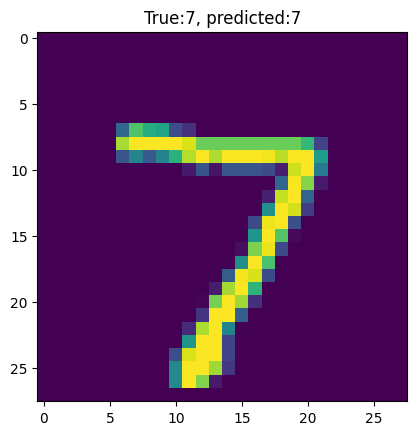

In [79]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

#### 2.3.3. <a id='toc2_3_3_'></a>[Evaluate the models](#toc0_)

In [80]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [81]:
print(evaluate_model(interpreter))

0.9593


Repeat the evaluation on the dynamic range quantized model to obtain:


In [82]:
print(evaluate_model(interpreter_quant))

0.9595


In this example, the compressed model has no difference in the accuracy.

### 2.4. <a id='toc2_4_'></a>[Optimizing an existing model](#toc0_)

Resnets with pre-activation layers (Resnet-v2) are widely used for vision applications.
  Pre-trained frozen graph for resnet-v2-101 is available on
  [Tensorflow Hub](https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4).

You can convert the frozen graph to a TensorFLow Lite flatbuffer with quantization by:


In [83]:
import tensorflow_hub as hub

resnet_v2_101 = tf.keras.Sequential([
  keras.layers.InputLayer(input_shape=(224, 224, 3)),
  hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4")
])

In [84]:
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_v2_101)

In [85]:
# Convert to TF Lite without quantization
resnet_tflite_file = tflite_models_dir/"resnet_v2_101.tflite"
resnet_tflite_file.write_bytes(converter.convert())

INFO:tensorflow:Assets written to: /tmp/tmpvp1olxjs/assets


INFO:tensorflow:Assets written to: /tmp/tmpvp1olxjs/assets
2023-06-27 21:48:13.320437: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:48:13.320458: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:48:13.320580: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpvp1olxjs
2023-06-27 21:48:13.336665: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:48:13.336686: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpvp1olxjs
2023-06-27 21:48:13.396879: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-06-27 21:48:13.858571: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpvp1olxjs
2023-06-27 21:48:14.030975: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

178426644

In [86]:
# Convert to TF Lite with quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
resnet_quantized_tflite_file = tflite_models_dir/"resnet_v2_101_quantized.tflite"
resnet_quantized_tflite_file.write_bytes(converter.convert())

INFO:tensorflow:Assets written to: /tmp/tmpcsds19wm/assets


INFO:tensorflow:Assets written to: /tmp/tmpcsds19wm/assets
2023-06-27 21:48:22.451044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:48:22.451067: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:48:22.451190: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpcsds19wm
2023-06-27 21:48:22.470733: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:48:22.470753: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpcsds19wm
2023-06-27 21:48:22.542699: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-06-27 21:48:22.980242: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpcsds19wm
2023-06-27 21:48:23.162326: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

46169720

In [87]:
!ls -lh {tflite_models_dir}/*.tflite

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
-rw-rw-r-- 1 cosmo cosmo  24K  6月 27 21:48 /tmp/mnist_tflite_models/mnist_model_quant.tflite
-rw-rw-r-- 1 cosmo cosmo  83K  6月 27 21:48 /tmp/mnist_tflite_models/mnist_model.tflite
-rw-rw-r-- 1 cosmo cosmo  45M  6月 27 21:48 /tmp/mnist_tflite_models/resnet_v2_101_quantized.tflite
-rw-rw-r-- 1 cosmo cosmo 171M  6月 27 21:48 /tmp/mnist_tflite_models/resnet_v2_101.tflite


The model size reduces from 171 MB to 43 MB.
The accuracy of this model on imagenet can be evaluated using the scripts provided for [TFLite accuracy measurement](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/tools/evaluation/tasks/imagenet_image_classification).

The optimized model top-1 accuracy is 76.8, the same as the floating point model.

## 3. <a id='toc3_'></a>[Post-training float16 quantization](#toc0_)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_float16_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

### 3.1. <a id='toc3_1_'></a>[Overview](#toc0_)

[TensorFlow Lite](https://www.tensorflow.org/lite/) now supports
converting weights to 16-bit floating point values during model conversion from TensorFlow to TensorFlow Lite's flat buffer format. This results in a 2x reduction in model size. Some hardware, like GPUs, can compute natively in this reduced precision arithmetic, realizing a speedup over traditional floating point execution. The Tensorflow Lite GPU delegate can be configured to run in this way. However, a model converted to float16 weights can still run on the CPU without additional modification: the float16 weights are upsampled to float32 prior to the first inference. This permits a significant reduction in model size in exchange for a minimal impacts to latency and accuracy.

In this tutorial, you train an MNIST model from scratch, check its accuracy in TensorFlow, and then convert the model into a Tensorflow Lite flatbuffer
with float16 quantization. Finally, check the accuracy of the converted model and compare it to the original float32 model.

### 3.2. <a id='toc3_2_'></a>[Build an MNIST model](#toc0_)

#### 3.2.1. <a id='toc3_2_1_'></a>[Setup](#toc0_)

In [88]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

#### 3.2.2. <a id='toc3_2_2_'></a>[Train and export the model](#toc0_)

In [89]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [90]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

In [91]:
# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

In [92]:
# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_data=(test_images, test_labels)
)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3016 - accuracy: 0.9137 - val_loss: 0.1584 - val_accuracy: 0.9546
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1366 - accuracy: 0.9607 - val_loss: 0.1027 - val_accuracy: 0.9700
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0987 - accuracy: 0.9715 - val_loss: 0.0839 - val_accuracy: 0.9735
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0789 - accuracy: 0.9771 - val_loss: 0.0713 - val_accuracy: 0.9778
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0659 - accuracy: 0.9808 - val_loss: 0.0634 - val_accuracy: 0.9790
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0565 - accuracy: 0.9831 - val_loss: 0.0622 - val_accuracy: 0.9793
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0500 - accuracy: 0.9850 - val_loss: 0.0591 - val_accuracy:

For the example, you trained the model for just a single epoch, so it only trains to ~96% accuracy.

#### 3.2.3. <a id='toc3_2_3_'></a>[Convert to a TensorFlow Lite model](#toc0_)

Using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), you can now convert the trained model into a TensorFlow Lite model.

Now load the model using the `TFLiteConverter`:

In [93]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp14b5z2md/assets


INFO:tensorflow:Assets written to: /tmp/tmp14b5z2md/assets
2023-06-27 21:49:17.967455: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:49:17.967471: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:49:17.967578: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp14b5z2md
2023-06-27 21:49:17.968311: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:49:17.968320: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp14b5z2md
2023-06-27 21:49:17.970784: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-06-27 21:49:17.988847: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp14b5z2md
2023-06-27 21:49:17.995087: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

Write it out to a `.tflite` file:

这段代码使用 Python 的 pathlib 模块创建了一个名为 "/tmp/mnist_tflite_models/" 的文件夹路径，并将其保存在一个名为 tflite_models_dir 的变量中。

接下来，调用 mkdir() 方法，将在本地文件系统上创建一个名为 "/tmp/mnist_tflite_models/" 的文件夹。如果文件夹已经存在，则不会抛出异常，因为 exist_ok=True 参数告诉 Python 在文件夹已经存在时不要引发异常。parents=True 参数告诉 Python 创建整个目录树，即如果上级目录不存在，也要一并创建。

这样，我们就可以使用 tflite_models_dir 变量引用 "/tmp/mnist_tflite_models/" 文件夹路径，以便在后续代码中使用该文件夹来存储 TFLite 模型文件。

In [94]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_models_dir

PosixPath('/tmp/mnist_tflite_models')

In [95]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84572

To instead quantize the model to float16 on export, first set the `optimizations` flag to use default optimizations. Then specify that float16 is the supported type on the target platform:

In [96]:
# 使用默认的优化方式对模型进行优化。
# 这些优化方式可以提高模型的性能和准确度，并减小模型文件的大小。
converter.optimizations = [tf.lite.Optimize.DEFAULT] 

# 将 converter 对象的 target_spec.supported_types 属性设置为 [tf.float16]，
# 表示在模型量化时使用 float16 数据类型。这将有助于减小模型的文件大小，
# 并提高模型在支持 float16 的硬件上的运行速度。
converter.target_spec.supported_types = [tf.float16] 

Finally, convert the model like usual. Note, by default the converted model will still use float input and outputs for invocation convenience.

In [97]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"mnist_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmpar3ieijw/assets


INFO:tensorflow:Assets written to: /tmp/tmpar3ieijw/assets


2023-06-27 21:49:18.326764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:49:18.326780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:49:18.326890: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpar3ieijw
2023-06-27 21:49:18.327714: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:49:18.327724: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpar3ieijw
2023-06-27 21:49:18.329915: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-06-27 21:49:18.346722: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpar3ieijw
2023-06-27 21:49:18.352582: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 25692 m

44268

Note how the resulting file is approximately `1/2` the size.

In [98]:
!ls -lh {tflite_models_dir}

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
總用量 215M
-rw-rw-r-- 1 cosmo cosmo  44K  6月 27 21:49 mnist_model_quant_f16.tflite
-rw-rw-r-- 1 cosmo cosmo  24K  6月 27 21:48 mnist_model_quant.tflite
-rw-rw-r-- 1 cosmo cosmo  83K  6月 27 21:49 mnist_model.tflite
-rw-rw-r-- 1 cosmo cosmo  45M  6月 27 21:48 resnet_v2_101_quantized.tflite
-rw-rw-r-- 1 cosmo cosmo 171M  6月 27 21:48 resnet_v2_101.tflite


### 3.3. <a id='toc3_3_'></a>[Run the TensorFlow Lite models](#toc0_)

Run the TensorFlow Lite model using the Python TensorFlow Lite Interpreter.

#### 3.3.1. <a id='toc3_3_1_'></a>[Load the model into the interpreters](#toc0_)

In [99]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [100]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

#### 3.3.2. <a id='toc3_3_2_'></a>[Test the models on one image](#toc0_)

In [101]:
import matplotlib.pyplot as plt

##### 3.3.2.1. <a id='toc3_3_2_1_'></a>[tflite_model testing](#toc0_)

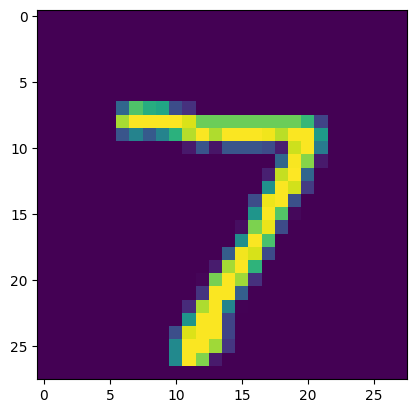

In [102]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)
plt.imshow(test_image.squeeze())

In [103]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

input_index, output_index

(0, 17)

In [104]:
interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)
predictions

array([[-10.997165  ,  -8.649213  ,  -4.5491643 ,   0.47341782,
         -8.491926  , -11.217087  , -30.570215  ,  10.592542  ,
         -5.8169765 ,  -2.5953789 ]], dtype=float32)

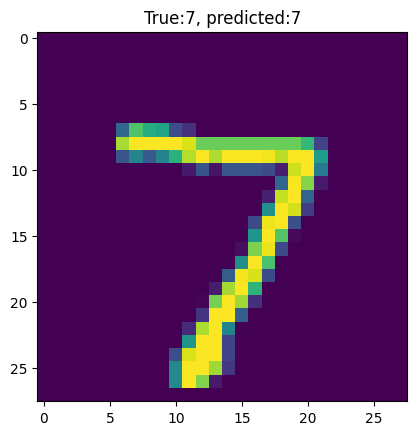

In [105]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

##### 3.3.2.2. <a id='toc3_3_2_2_'></a>[Quantized tflite_model testing](#toc0_)

In [106]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_image)
interpreter_fp16.invoke()
predictions = interpreter_fp16.get_tensor(output_index)

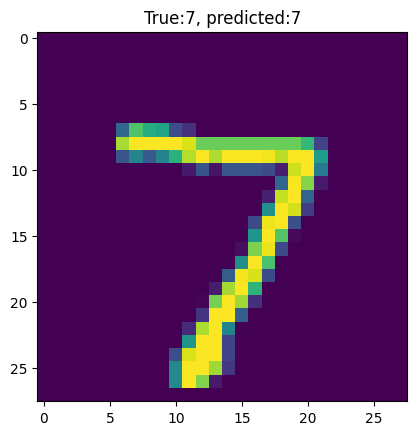

In [107]:
plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

#### 3.3.3. <a id='toc3_3_3_'></a>[Evaluate the models](#toc0_)

In [108]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [109]:
print(evaluate_model(interpreter))

0.9835


Repeat the evaluation on the float16 quantized model to obtain:

In [110]:
# NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite
# doesn't have super optimized server CPU kernels. For this reason this may be
# slower than the above float interpreter. But for mobile CPUs, considerable
# speedup can be observed.
print(evaluate_model(interpreter_fp16))

0.9835


In this example, you have quantized a model to float16 with no difference in the accuracy.

It's also possible to evaluate the fp16 quantized model on the GPU. To perform all arithmetic with the reduced precision values, be sure to create the `TfLiteGPUDelegateOptions` struct in your app and set `precision_loss_allowed` to `1`, like this:

```
//Prepare GPU delegate.
const TfLiteGpuDelegateOptions options = {
  .metadata = NULL,
  .compile_options = {
    .precision_loss_allowed = 1,  // FP16
    .preferred_gl_object_type = TFLITE_GL_OBJECT_TYPE_FASTEST,
    .dynamic_batch_enabled = 0,   // Not fully functional yet
  },
};
```

Detailed documentation on the TFLite GPU delegate and how to use it in your application can be found [here](https://www.tensorflow.org/lite/performance/gpu_advanced?source=post_page---------------------------)

## 4. <a id='toc4_'></a>[Post-training integer quantization](#toc0_)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

### 4.1. <a id='toc4_1_'></a>[Overview](#toc0_)

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This results in a smaller model and increased inferencing speed, which is valuable for low-power devices such as [microcontrollers](https://www.tensorflow.org/lite/microcontrollers). This data format is also required by integer-only accelerators such as the [Edge TPU](https://coral.ai/).

In this tutorial, you'll train an MNIST model from scratch, convert it into a Tensorflow Lite file, and quantize it using [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). Finally, you'll check the accuracy of the converted model and compare it to the original float model.

You actually have several options as to how much you want to quantize a model. In this tutorial, you'll perform "full integer quantization," which converts all weights and activation outputs into 8-bit integer data—whereas other strategies may leave some amount of data in floating-point.

To learn more about the various quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).


### 4.2. <a id='toc4_2_'></a>[Setup](#toc0_)

In order to quantize both the input and output tensors, we need to use APIs added in TensorFlow 2.3:

In [111]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.8.3


### 4.3. <a id='toc4_3_'></a>[Generate a TensorFlow Model](#toc0_)

We'll build a simple model to classify numbers from the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist).

This training won't take long because you're training the model for just a 5 epochs, which trains to about ~98% accuracy.

In [112]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2689 - accuracy: 0.9249 - val_loss: 0.1138 - val_accuracy: 0.9669
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1070 - accuracy: 0.9688 - val_loss: 0.0860 - val_accuracy: 0.9727
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0793 - accuracy: 0.9765 - val_loss: 0.0722 - val_accuracy: 0.9756
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0650 - accuracy: 0.9815 - val_loss: 0.0625 - val_accuracy: 0.9781
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0559 - accuracy: 0.9836 - val_loss: 0.0589 - val_accuracy: 0.9806


### 4.4. <a id='toc4_4_'></a>[Convert to a TensorFlow Lite model](#toc0_)

Now you can convert the trained model to TensorFlow Lite format using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), and apply varying degrees of quantization.

Beware that some versions of quantization leave some of the data in float format. So the following sections show each option with increasing amounts of quantization, until we get a model that's entirely int8 or uint8 data. (Notice we duplicate some code in each section so you can see all the quantization steps for each option.)

First, here's a converted model with no quantization:

In [113]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpa2awgmj0/assets


INFO:tensorflow:Assets written to: /tmp/tmpa2awgmj0/assets
2023-06-27 21:49:45.161060: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:49:45.161076: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:49:45.161177: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpa2awgmj0
2023-06-27 21:49:45.161849: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:49:45.161860: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpa2awgmj0
2023-06-27 21:49:45.164081: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-06-27 21:49:45.180205: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpa2awgmj0
2023-06-27 21:49:45.185744: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data.

#### 4.4.1. <a id='toc4_4_1_'></a>[Convert using dynamic range quantization](#toc0_)


Now let's enable the default `optimizations` flag to quantize all fixed parameters (such as weights):

In [114]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpisy4l4bn/assets


INFO:tensorflow:Assets written to: /tmp/tmpisy4l4bn/assets
2023-06-27 21:49:45.495970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:49:45.495986: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:49:45.496090: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpisy4l4bn
2023-06-27 21:49:45.496715: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:49:45.496724: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpisy4l4bn
2023-06-27 21:49:45.498778: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-06-27 21:49:45.514845: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpisy4l4bn
2023-06-27 21:49:45.520052: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

The model is now a bit smaller with quantized weights, but other variable data is still in float format.

#### 4.4.2. <a id='toc4_4_2_'></a>[Convert using float fallback quantization](#toc0_)

To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.)
To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.


In [115]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpqfkhqisr/assets


INFO:tensorflow:Assets written to: /tmp/tmpqfkhqisr/assets
/home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-27 21:49:45.825754: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:49:45.825769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:49:45.825871: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpqfkhqisr
2023-06-27 21:49:45.826476: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:49:45.826485: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpqfkhqisr
2023-06-27 21:49:45.828424: I 

Now all weights and variable data are quantized, and the model is significantly smaller compared to the original TensorFlow Lite model.

However, to maintain compatibility with applications that traditionally use float model input and output tensors, the TensorFlow Lite Converter leaves the model input and output tensors in float:

In [116]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


That's usually good for compatibility, but it won't be compatible with devices that perform only integer-based operations, such as the Edge TPU.

Additionally, the above process may leave an operation in float format if TensorFlow Lite doesn't include a quantized implementation for that operation. This strategy allows conversion to complete so you have a smaller and more efficient model, but again, it won't be compatible with integer-only hardware. (All ops in this MNIST model have a quantized implementation.)

So to ensure an end-to-end integer-only model, you need a couple more parameters...

#### 4.4.3. <a id='toc4_4_3_'></a>[Convert using integer-only quantization](#toc0_)

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [117]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp2ja094gu/assets


INFO:tensorflow:Assets written to: /tmp/tmp2ja094gu/assets
/home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-27 21:49:46.358066: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-27 21:49:46.358082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-27 21:49:46.358185: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp2ja094gu
2023-06-27 21:49:46.358772: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-27 21:49:46.358781: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp2ja094gu
2023-06-27 21:49:46.360690: I 

The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:


In [118]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Now you have an integer quantized model that uses integer data for the model's input and output tensors, so it's compatible with integer-only hardware such as the [Edge TPU](https://coral.ai).

#### 4.4.4. <a id='toc4_4_4_'></a>[Save the models as files](#toc0_)

You'll need a `.tflite` file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [119]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant_int.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24368

In [120]:
!ls -lh {tflite_models_dir}

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
總用量 215M
-rw-rw-r-- 1 cosmo cosmo  44K  6月 27 21:49 mnist_model_quant_f16.tflite
-rw-rw-r-- 1 cosmo cosmo  24K  6月 27 21:49 mnist_model_quant_int.tflite
-rw-rw-r-- 1 cosmo cosmo  24K  6月 27 21:48 mnist_model_quant.tflite
-rw-rw-r-- 1 cosmo cosmo  83K  6月 27 21:49 mnist_model.tflite
-rw-rw-r-- 1 cosmo cosmo  45M  6月 27 21:48 resnet_v2_101_quantized.tflite
-rw-rw-r-- 1 cosmo cosmo 171M  6月 27 21:48 resnet_v2_101.tflite


### 4.5. <a id='toc4_5_'></a>[Run the TensorFlow Lite models](#toc0_)

Now we'll run inferences using the TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) to compare the model accuracies.

First, we need a function that runs inference with a given model and images, and then returns the predictions:


In [121]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


#### 4.5.1. <a id='toc4_5_1_'></a>[Test the models on one image](#toc0_)


Now we'll compare the performance of the float model and quantized model:
+ `tflite_model_file` is the original TensorFlow Lite model with floating-point data.
+ `tflite_model_quant_file` is the last model we converted using integer-only quantization (it uses uint8 data for input and output).

Let's create another function to print our predictions:

In [122]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

Now test the float model:

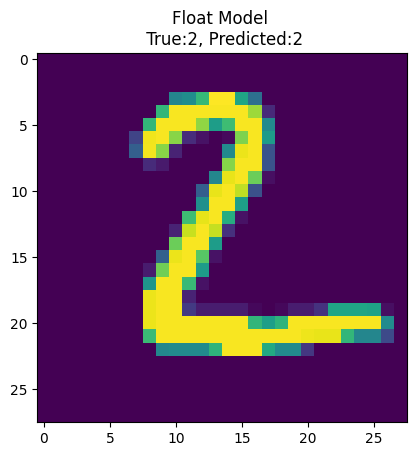

In [123]:
test_model(tflite_model_file, test_image_index, model_type="Float")

And test the quantized model:

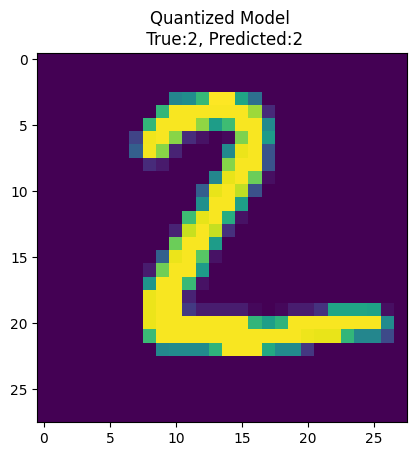

In [124]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

#### 4.5.2. <a id='toc4_5_2_'></a>[Evaluate the models on all images](#toc0_)

Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [125]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Evaluate the float model:

In [126]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 98.0600% (Number of test samples=10000)


Evaluate the quantized model:

In [127]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 98.0300% (Number of test samples=10000)


So you now have an integer quantized a model with almost no difference in the accuracy, compared to the float model.

To learn more about other quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).

## 5. <a id='toc5_'></a>[Delete all files](#toc0_)

In [128]:
!rm -rf {tflite_models_dir}/*

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
